In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import imutils

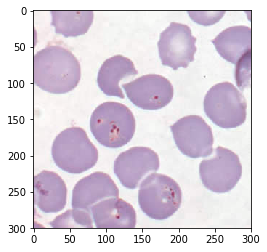

In [2]:
img_original = cv.imread('img.jpeg', cv.IMREAD_COLOR)
plt.imshow(img_original)

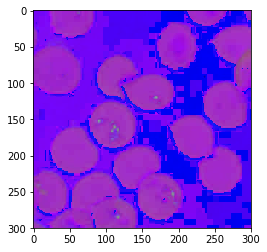

In [3]:
hsv = cv.cvtColor(img_original, cv.COLOR_BGR2HSV)
plt.imshow(hsv)

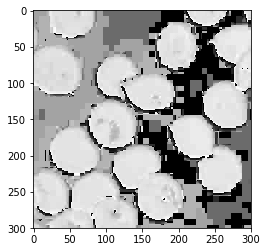

In [4]:
h, s, v = cv.split(hsv)
s_inv = cv.bitwise_not(s)
plt.imshow(h, cmap='gray')

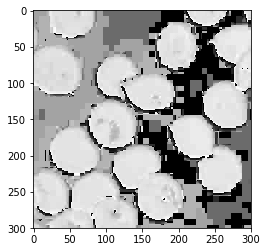

In [5]:
plt.imshow(h, cmap='gray')

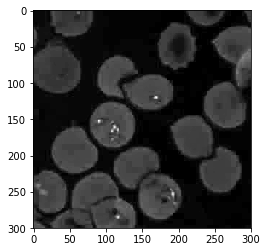

In [6]:
plt.imshow(s, cmap='gray')

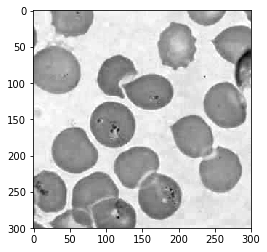

In [7]:
plt.imshow(v, cmap='gray')

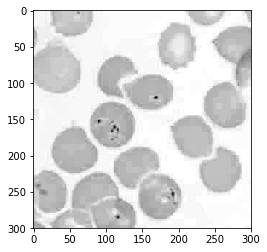

In [8]:
plt.imshow(s_inv, cmap='gray')

In [9]:
Z = s_inv.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((s_inv.shape))

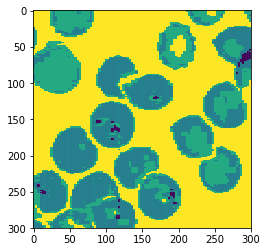

In [10]:
plt.imshow(res2)

## TRABAJAR CON S_INV

(-0.5, 299.5, 299.5, -0.5)

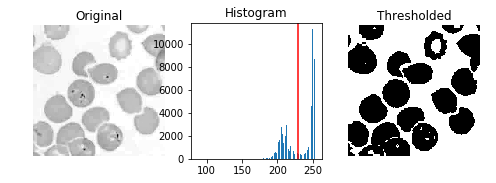

In [11]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(s_inv)
binary = s_inv > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(s_inv, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(s_inv.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

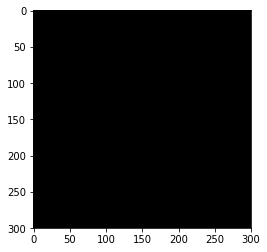

In [12]:
def img_fill(im_th):  # n = binary image threshold
    # th, im_th = cv2.threshold(im_in, n, 255, cv2.THRESH_BINARY);

    # Copy the thresholded image.
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)

    # Floodfill from point (0, 0)
    cv.floodFill(im_floodfill, mask, (0, 0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    fill_image = im_th | im_floodfill_inv

    return fill_image 
ret, mask_dsease = cv.threshold(s_inv, 1, 255, cv.THRESH_BINARY)
ret, OTSU_BIN_METHOD = cv.threshold(s_inv, 1, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
flood_fll = img_fill(OTSU_BIN_METHOD)
plt.imshow(OTSU_BIN_METHOD, cmap='gray')
plt.imshow(flood_fll, cmap='gray')

## Suavizado de canal S y Binarización por otsu

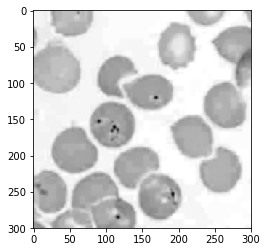

In [13]:
blur = cv.GaussianBlur(s_inv,(5,5),0)
plt.imshow(blur, cmap='gray')

In [14]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

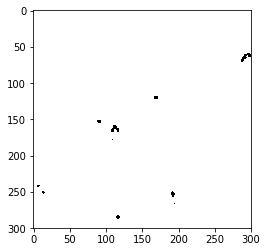

In [15]:
# threshold 
th, th_enf = cv.threshold(blur, 180, 255, cv.THRESH_BINARY_INV) 
plt.imshow(flood_fll - th_enf, cmap='gray')

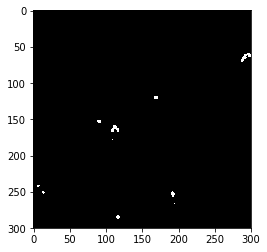

In [16]:
plt.imshow(th_enf, cmap='gray')

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [18]:
# remove artifacts connected to image border
cleared = clear_border(th_enf)

/home/ospcx/anaconda3/envs/pyimg/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/ospcx/anaconda3/envs/pyimg/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


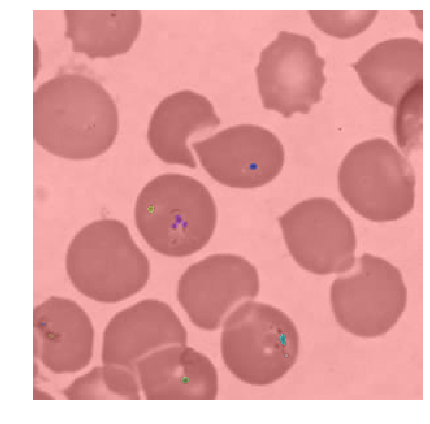

In [19]:
# label image regions
image = img_as_ubyte(img_original)
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

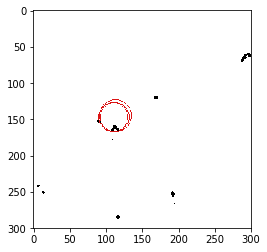

In [21]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage import data, color

# Load picture and detect edges
image = img_as_ubyte(flood_fll - th_enf)
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)


# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()